### [Hypothesis-revisited] Proportion of TPP-EMIS error code 99s will have reduced from February to April 
#### Story PRMT-1955(Feb-Mar) + PRMT-2057(+April)
### Hypothesis

**We believe** that transfers resulting in error code 99’s from TPP to EMIS

**Will** have reduced in proportion from February to April 2021

**We will know this to be true when** we see that the % of all TPP-EMIS transfers resulting is this error over the months in question
 

### Scope
- Generate a break down of error codes per supplier pathway for February, and a separate one for March
- Identify the total number of TPP-EMIS transfers for both February and March
- Calculate what % of the total number of TPP-EMIS transfers resulted in error code 99, for both February and March

### Acceptance Criteria
- We know whether the proportion of error code 99s has decreased
- We have a confluence page that shows the two monthly breakdowns - specifically a comparison of the proportions of the error code 99s between TPP-EMIS and EMIS-EMIS

## Import and prep data

In [1]:
import matplotlib.pyplot as plt 

In [2]:
import pandas as pd
import numpy as np

# Using data generated from branch PRMT-1742-duplicates-analysis.
# This is needed to correctly handle duplicates.
# Once the upstream pipeline has a fix for duplicate EHRs, then we can go back to using the main output.
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-5/"
transfer_files = [
    "2021-2-transfers.parquet",
    "2021-3-transfers.parquet",
    "2021-4-transfers.parquet",
]

transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

# In the data from the PRMT-1742-duplicates-analysis branch, these columns have been added, but contain only empty values.
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)

transfers = transfers_raw.copy()

# Correctly interpret certain sender errors as failed.
# This is explained in PRMT-1974. Eventually this will be fixed upstream in the pipeline. 
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

# Add integrated Late status
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'

# If the record integrated after 28 days, change the status back to pending.
# This is to handle each month consistentently and to always reflect a transfers status 28 days after it was made.
# TBD how this is handled upstream in the pipeline
twenty_eight_days_in_seconds=28*24*60*60
transfers_after_month_bool=transfers['sla_duration']>twenty_eight_days_in_seconds
transfers_pending_at_month_bool=transfers_after_month_bool & transfers_integrated_late_bool
transfers.loc[transfers_pending_at_month_bool,'status']='PENDING'
transfers_with_early_error_bool=(~transfers.loc[:,'sender_error_code'].isna()) |(~transfers.loc[:,'intermediate_error_codes'].apply(len)>0)
transfers.loc[transfers_with_early_error_bool & transfers_pending_at_month_bool,'status']='PENDING_WITH_ERROR'

# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)
lookup = asid_lookup[["ASID", "MName", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code','OrgName':'requesting_practice_name'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code','OrgName':'sending_practice_name'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

In [3]:
transfers.columns

Index(['conversation_id', 'sla_duration', 'requesting_practice_asid',
       'sending_practice_asid', 'sender_error_code', 'final_error_codes',
       'intermediate_error_codes', 'status', 'date_requested',
       'date_completed', 'requesting_supplier_asid', 'requesting_supplier',
       'requesting_ods_code', 'requesting_practice_name',
       'sending_supplier_asid', 'sending_supplier', 'sending_ods_code',
       'sending_practice_name'],
      dtype='object')

In [4]:
# Filter for the transfers relevant to the question and rename month
relevant_pathway_bool=(transfers['sending_supplier'].isin(['TPP','EMIS'])) & (transfers['requesting_supplier']=='EMIS')
relevant_transfers=transfers.copy().loc[relevant_pathway_bool]
relevant_transfers['Month']=relevant_transfers['date_requested'].dt.month.replace({1:'1. January',2:'2. February',3:'3. March', 4:'4. April'})

# Combine all error codes into a single unique set of error codes
relevant_transfers['all_errors']=relevant_transfers.apply(lambda row:np.concatenate((np.append(row["intermediate_error_codes"], row["sender_error_code"]),row['final_error_codes'])), axis=1)
relevant_transfers['all_errors']=relevant_transfers['all_errors'].apply(lambda error_list:[error for error in error_list if np.isfinite(error)])
relevant_transfers['unique_errors']=relevant_transfers['all_errors'].apply(set).apply(list)

# Add in which transfers contain error code 99
relevant_transfers['Contains error code 99']=relevant_transfers['unique_errors'].apply(lambda error_list: 99 in error_list).astype(int)

In [5]:
# Relabel status for readability
relevant_transfers['Status at 28 days']=relevant_transfers['status'].apply(lambda x: x.replace('_',' ').title())
relevant_transfers.loc[relevant_transfers['Status at 28 days']=="Pending","Status at 28 days"]="Pending Without Error"

In [6]:
# Add in supplier pathway
relevant_transfers['Supplier Pathway']=relevant_transfers['sending_supplier'] + ' to ' + relevant_transfers['requesting_supplier']

### A. What proportion of transfers still have Error Code 99?

In [7]:
change_in_99=relevant_transfers.groupby(['Supplier Pathway','Month']).agg({'Contains error code 99':['count','sum','mean']})
change_in_99=change_in_99['Contains error code 99'].rename({'count':'Total Transfers','sum':'Transfers with Error 99','mean':'% Transfers with Error 99'},axis=1)
change_in_99['% Transfers with Error 99']=change_in_99['% Transfers with Error 99'].multiply(100).round(2)
change_in_99

Total Transfers  Transfers with Error 99  \
Supplier Pathway Month                                                   
EMIS to EMIS     2. February           142597                      215   
                 3. March              186714                      263   
                 4. April              144995                      261   
TPP to EMIS      2. February            39360                     1580   
                 3. March               51724                      875   
                 4. April               39631                      170   

                              % Transfers with Error 99  
Supplier Pathway Month                                   
EMIS to EMIS     2. February                       0.15  
                 3. March                          0.14  
                 4. April                          0.18  
TPP to EMIS      2. February                       4.01  
                 3. March                          1.69  
                 4. April                          0.43

### B. What is the change in status?

In [8]:
column_order=['Integrated','Integrated Late','Pending Without Error','Pending With Error','Failed']
status_table=relevant_transfers.pivot_table(index=['Supplier Pathway','Month'],columns='Status at 28 days',values='conversation_id',aggfunc='count')
status_table=status_table[column_order]
status_table_percentage=status_table.div(status_table.sum(axis=1),axis=0).multiply(100).round(2)
status_table_percentage.columns=status_table_percentage.columns + ' %'
pd.concat([status_table,status_table_percentage],axis=1)

Status at 28 days             Integrated  Integrated Late  \
Supplier Pathway Month                                      
EMIS to EMIS     2. February      131210             6676   
                 3. March         168285            10807   
                 4. April         131520             7852   
TPP to EMIS      2. February       33513             1815   
                 3. March          44808             3025   
                 4. April          34689             2259   

Status at 28 days             Pending Without Error  Pending With Error  \
Supplier Pathway Month                                                    
EMIS to EMIS     2. February                   2931                 548   
                 3. March                      4467                1551   
                 4. April                      3090                1130   
TPP to EMIS      2. February                    879                  47   
                 3. March                       987                  85   
                 4. April                       761                  79   

Status at 28 days             Failed  Integrated %  Integrated Late %  \
Supplier Pathway Month                                                  
EMIS to EMIS     2. February    1232         92.01               4.68   
                 3. March       1604         90.13               5.79   
                 4. April       1403         90.71               5.42   
TPP to EMIS      2. February    3106         85.14               4.61   
                 3. March       2819         86.63               5.85   
                 4. April       1843         87.53               5.70   

Status at 28 days             Pending Without Error %  Pending With Error %  \
Supplier Pathway Month                                                        
EMIS to EMIS     2. February                     2.06                  0.38   
                 3. March                        2.39                  0.83   
                 4. April                        2.13                  0.78   
TPP to EMIS      2. February                     2.23                  0.12   
                 3. March                        1.91                  0.16   
                 4. April                        1.92                  0.20   

Status at 28 days             Failed %  
Supplier Pathway Month                  
EMIS to EMIS     2. February      0.86  
                 3. March         0.86  
                 4. April         0.97  
TPP to EMIS      2. February      7.89  
                 3. March         5.45  
                 4. April         4.65

### C. Can we attribute status changes to the reduction of Error code 99?

In [9]:
# Create a new field that combines the status and if the transfer contained error 99
contains_99={0:'(No 99)',1:'(Contains 99)'}
relevant_transfers['status and presence of 99']=relevant_transfers.apply(lambda row: row['Status at 28 days']+ ' '+contains_99[row['Contains error code 99']],axis=1)

#### Number of transfers per status and instance of error code 99s

In [10]:
status_and_99_table_count=relevant_transfers.pivot_table(index=['Supplier Pathway','Month'],columns='status and presence of 99',values='status',aggfunc='count').fillna(0).astype(int)
new_column_order=['Integrated (No 99)','Integrated (Contains 99)','Integrated Late (No 99)','Integrated Late (Contains 99)','Pending Without Error (No 99)','Pending Without Error (Contains 99)','Pending With Error (No 99)','Pending With Error (Contains 99)','Failed (No 99)','Failed (Contains 99)']
# Filter out any columns that have no associated transfers
new_column_order=[column_name for column_name in new_column_order if column_name in status_and_99_table_count.columns]
status_and_99_table_count=status_and_99_table_count.loc[:, new_column_order]

status_and_99_table_count

status and presence of 99     Integrated (No 99)  Integrated (Contains 99)  \
Supplier Pathway Month                                                       
EMIS to EMIS     2. February              131204                         6   
                 3. March                 168277                         8   
                 4. April                 131509                        11   
TPP to EMIS      2. February               33504                         9   
                 3. March                  44790                        18   
                 4. April                  34685                         4   

status and presence of 99     Integrated Late (No 99)  \
Supplier Pathway Month                                  
EMIS to EMIS     2. February                     6676   
                 3. March                       10807   
                 4. April                        7850   
TPP to EMIS      2. February                     1815   
                 3. March                        3024   
                 4. April                        2259   

status and presence of 99     Integrated Late (Contains 99)  \
Supplier Pathway Month                                        
EMIS to EMIS     2. February                              0   
                 3. March                                 0   
                 4. April                                 2   
TPP to EMIS      2. February                              0   
                 3. March                                 1   
                 4. April                                 0   

status and presence of 99     Pending Without Error (No 99)  \
Supplier Pathway Month                                        
EMIS to EMIS     2. February                           2931   
                 3. March                              4467   
                 4. April                              3090   
TPP to EMIS      2. February                            879   
                 3. March                               987   
                 4. April                               761   

status and presence of 99     Pending With Error (No 99)  \
Supplier Pathway Month                                     
EMIS to EMIS     2. February                         548   
                 3. March                           1551   
                 4. April                           1130   
TPP to EMIS      2. February                          45   
                 3. March                             85   
                 4. April                             79   

status and presence of 99     Pending With Error (Contains 99)  \
Supplier Pathway Month                                           
EMIS to EMIS     2. February                                 0   
                 3. March                                    0   
                 4. April                                    0   
TPP to EMIS      2. February                                 2   
                 3. March                                    0   
                 4. April                                    0   

status and presence of 99     Failed (No 99)  Failed (Contains 99)  
Supplier Pathway Month                                              
EMIS to EMIS     2. February            1023                   209  
                 3. March               1349                   255  
                 4. April               1155                   248  
TPP to EMIS      2. February            1537                  1569  
                 3. March               1963                   856  
                 4. April               1677                   166

#### Percentage of transfers per status and instance of error code 99s

In [11]:
status_and_99_table_percentage=status_and_99_table_count.div(status_and_99_table_count.sum(axis=1),axis=0).multiply(100)
status_and_99_table_percentage.round(2)

status and presence of 99     Integrated (No 99)  Integrated (Contains 99)  \
Supplier Pathway Month                                                       
EMIS to EMIS     2. February               92.01                      0.00   
                 3. March                  90.13                      0.00   
                 4. April                  90.70                      0.01   
TPP to EMIS      2. February               85.12                      0.02   
                 3. March                  86.59                      0.03   
                 4. April                  87.52                      0.01   

status and presence of 99     Integrated Late (No 99)  \
Supplier Pathway Month                                  
EMIS to EMIS     2. February                     4.68   
                 3. March                        5.79   
                 4. April                        5.41   
TPP to EMIS      2. February                     4.61   
                 3. March                        5.85   
                 4. April                        5.70   

status and presence of 99     Integrated Late (Contains 99)  \
Supplier Pathway Month                                        
EMIS to EMIS     2. February                            0.0   
                 3. March                               0.0   
                 4. April                               0.0   
TPP to EMIS      2. February                            0.0   
                 3. March                               0.0   
                 4. April                               0.0   

status and presence of 99     Pending Without Error (No 99)  \
Supplier Pathway Month                                        
EMIS to EMIS     2. February                           2.06   
                 3. March                              2.39   
                 4. April                              2.13   
TPP to EMIS      2. February                           2.23   
                 3. March                              1.91   
                 4. April                              1.92   

status and presence of 99     Pending With Error (No 99)  \
Supplier Pathway Month                                     
EMIS to EMIS     2. February                        0.38   
                 3. March                           0.83   
                 4. April                           0.78   
TPP to EMIS      2. February                        0.11   
                 3. March                           0.16   
                 4. April                           0.20   

status and presence of 99     Pending With Error (Contains 99)  \
Supplier Pathway Month                                           
EMIS to EMIS     2. February                              0.00   
                 3. March                                 0.00   
                 4. April                                 0.00   
TPP to EMIS      2. February                              0.01   
                 3. March                                 0.00   
                 4. April                                 0.00   

status and presence of 99     Failed (No 99)  Failed (Contains 99)  
Supplier Pathway Month                                              
EMIS to EMIS     2. February            0.72                  0.15  
                 3. March               0.72                  0.14  
                 4. April               0.80                  0.17  
TPP to EMIS      2. February            3.90                  3.99  
                 3. March               3.80                  1.65  
                 4. April               4.23                  0.42

In [12]:
lm_color_table=dict()
lm_color_table['Integrated (No 99)']='#9EE09E'
lm_color_table['Integrated (Contains 99)']='#FFF'
lm_color_table['Integrated Late (No 99)']='#9EC1CF'
lm_color_table['Integrated Late (Contains 99)']='#FFF'
lm_color_table['Pending Without Error (No 99)']='#CC99C9'
lm_color_table['Pending With Error (No 99)']='#FDFD97'

lm_color_table['Pending With Error (Contains 99)']='#FFF'
lm_color_table['Failed (Contains 99)']='#FF6663'
lm_color_table['Failed (No 99)']='#FEB144'


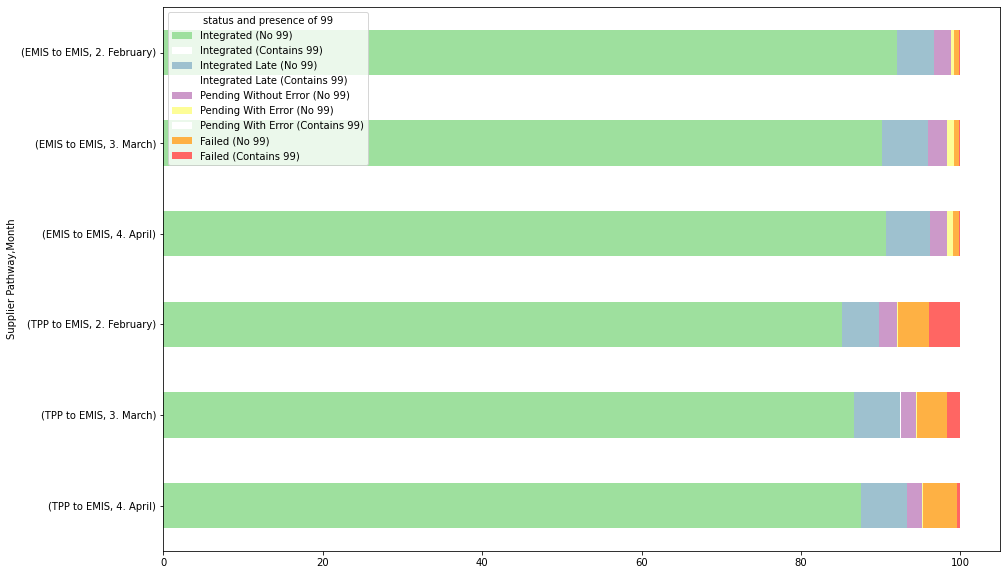

In [13]:
status_and_99_table_percentage.plot.barh(stacked=True,figsize=(15,10),color=lm_color_table)
plt.gca().invert_yaxis()